# Single-parameter gradient descent

The goal of this lecture/lab is to solve a nontrivial iterative computation problem: *gradient-descent function minimization*. My hope is that you will see gradient descent as identical to the square root approximation, just with a different recurrence relation. The full [source code](https://github.com/parrt/msan501/blob/master/notes/code/descent.py) of this lesson is available.

## Discussion

Finding $x$ that minimizes or "optimizes" function $f(x)$ (usually over some range) is an incredibly important operation as we can use it to minimize risk and, for machine learning, to learn the parameters of our classifiers or predictors. For example, deep learning uses cost function optimization to train neural networks. Generally $x$ will be a vector but we will assume $x$ is a scalar to learn the basics. If we know that the function is convex like a quadratic polynomial, there is a unique solution and we can simply set the derivative equal to zero and solve for $x$:

\\[
f'(x) = 0
\\]

That is basically asking the question, "Where does the function flatten out?"  For example, the function $f(x) = (x-2)^2 + 1$ has derivative $f'(x) = 2x - 4$ whose zero is $x=2$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def f(x): return (x - 2)**2 + 1

graphx = np.arange(0, 4, 0.01)
graphy = f(graphx) # apply f to all of graphx (BROADCAST)
plt.plot(graphx, graphy)
plt.show()

<Figure size 640x480 with 1 Axes>

We prefer to find the *global minimum* of $f(x)$ but generally have to be satisfied with a *local minimum*, which we hope is close to the global minimum. A decent approach to finding the global minimum is to find a number of local minima via random starting $x_0$ locations and just choose the $x$ of the smallest minimum $f(x)$ discovered. For example, the function $f(x) = cos(3\pi x) / x$ has two minima in $[0,1.3]$, with one obvious global minimum:

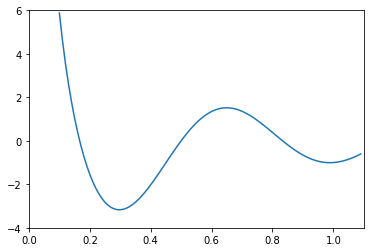

In [2]:
def f(x): return np.cos(3 * np.pi * x) / x

graphx = np.arange(.1, 1.1, 0.01)
graphy = f(graphx)
plt.plot(graphx, graphy)
plt.axis([0, 1.1, -4, 6])
plt.show()

If the function has lots of minima/maxima or is very complicated, there may be no easy analytic solution.
There are many approaches to finding function minima iteratively (i.e., non-analytically), but we will use a well-known technique called *gradient descent* or *method of steepest descent*.  

### Gradient descent

Gradient descent requires a starting position, $x_0$, the function to optimize, $f(x)$, and its derivative $f'(x)$.  Recall that the derivative is just the slope of a function at a particular point. In other words, as $x$ shifts away from a specific position, does $f(x)$ go up or down, and by how much?  E.g., the derivative of $x^2$ is $2x$, which gives us a positive slope when $x>0$ and a negative slope when $x<0$.  Gradient descent uses the derivative to iteratively pick a new value of $x$ that gets us closer and closer to the minimum of $f(x)$.   The negative of the slope tells us the direction (in $x$ units) of the nearest minimum. For example, here is the cosine graph again, this time showing a number of vectors representing derivatives at particular points.

<img src="images/cos-2minima-edited.png" width="300">

Note that the derivative is zero, i.e. flat, at the minima (same is true for maxima). Notice that the derivatives (red vectors) point in the opposite direction of the nearest minimum. If we want to move in the direction of the nearest minimum, we should adjust $x$ by adding the negative of the derivative; i.e., we should subtract the derivative from $x_i$ to get $x_{i+1}$.  The recurrence relation for updating our estimate of $x$ that minimizes $f(x)$ is then just:

\\[
x_{i+1} = x_i - \eta f'(x_i)
\\]

where $\eta$ is called the *learning rate*, which we'll discuss below. The $\eta f'(x_{i})$ term represents the size of the step we take towards the minimum. 
The basic algorithm is:

<ol>
    <li>Pick an initial $x_0$, let $x = x_0$
    <li>Let $x_{i+1} = x_i - \eta f'(x_i)$ until $f'(x_i)=0$
</ol>

That algorithm is extremely simple but knowing when to stop the algorithm is problematic when dealing with the finite precision of computers. Specifically, no two floating-point numbers are ever equal really. So $f'(x) = 0$ is always false. Usually we do something like

\\[
abs(x_{i+1} - x_i) < precision
\\]

where precision is some very small number like 0.0000001.  We could also test 

\\[
abs(f(x_{i+1}) - f(x_i)) < precision
\\]

to see if the function is flattening out or when there is a very small vertical change **and** $f(x_{i+1})$ is heading back up.  A third way is to test whether the derivative is close to zero. I tried all three and found that simply checking to see if $x_{i+1}$ has converged works the best (it, for example, allowed me to have a very high learning rate). The third method is problematic because we are using finite difference, which is a poor approximation to the true derivative.

The steps we take are scaled by the learning rate $\eta$.  Yaser S. Abu-Mostafa has some [great slides](http://www.amlbook.com/slides/iTunesU_Lecture09_May_01.pdf) and videos that you should check out. Here is his description on slide 21 of how the learning rate can affect convergence:

<img src="images/stepsize.png" width="400">

The domain of $x$ also affects the learning rate magnitude. This is all a very complicated finicky business and those experienced in the field tell me it's very much an art picking the learning rate, starting positions, precision, and so on. You can start out with a low learning rate and crank it up to see if you still converge without oscillating around the minimum.  An excellent description of gradient descent and other minimization techniques can be found in [Numerical Recipes](http://apps.nrbook.com/fortran/index.html).

### Approximating derivatives with finite differences

Sometimes, the derivative is hard, expensive, or impossible to find analytically (symbolically).  For example, some functions are themselves iterative in nature or even simulations that must be optimized. There might be no closed form for $f(x)$. To get around this and to reduce the input requirements, we can approximate the derivative in the neighborhood of a particular $x$ value. That way we can optimize any reasonably well behaved function (left and right continuity would be nice). Our minimizer then only requires a starting location and $f(x)$ but not $f'(x)$, which makes the lives of our users much simpler and our minimizer much more flexible. 

To approximate the derivative, we can take several approaches. The simplest involves a comparison. Since we really just need a direction, all we have to do is compare the current $f(x_i)$ with values a small step, $h$, away in either direction: $f(x_{i}-h)$ and $f(x_{i}+h)$.  If $f(x_{i}-h) < f(x_{i})$, we should move $x_{i+1}$ to the left of $x_{i}$. If $f(x_{i}+h) < f(x_{i})$, we should move $x_{i+1}$ to the right.  These are called the backward and forward differences, but there is also a central difference. The excellent article [Stochastic Gradient Descent Tricks](http://research.microsoft.com/pubs/192769/tricks-2012.pdf) has a lot of practical information on computing gradients etc...

Using the direction of the slope works, but does not converge very fast. What we really want is to use the magnitude of the slope to make the algorithm go fast where it's steep and slow where it's shallow because it will be approaching a minimum. So, rather than just using the sign of the finite difference, we should use the magnitude or rate of change. Replacing the derivative in our recurrence relation with the finite (forward) difference, we get a similar formula:

\\[
x _{i+1} = x_i - \eta \frac{f(x_{i}+h) - f(x_{i})}{h} \text{ where } f'(x) \approx \frac{f(x_{i}+h) - f(x_{i})}{h}
\\]

To simplify things, we can roll the step size $h$ into the learning rate $\eta$ constant as we are going to pick that anyway.

\\[
x _{i+1} = x_i - \eta (f(x_{i}+h) - f(x_{i}))
\\]

 The step size is bigger when the slope is bigger and is smaller as we approach the minimum (since the region is flatter). Abu-Mostafa indicates in his slides that $\eta$ should increase with the slope whereas we are keeping it fixed and allowing the finite difference to increase the step size. We are not normalizing the derivative/difference to a unit vector like he does (see his slides).

## An implementation

Our goal is to use gradient descent to minimize $f(x) = cos(3\pi x) / x$. To increase chances of finding the global minimum, we can pick a few random starting locations in the range $[0.1,1.3]$ using standard python {\tt random.uniform()} and perform gradient descent on all of them. To  observe our minimizer in action, we'll eventually plot the trace of $x$'s that indicate the steps taken by our gradient descent. Here are two sample descents where the $x$ and $f(x)$ values are displayed as well as the minima:

<table border=0>
    <tr border=0><td border=0><img src="images/cos-trace-2minima.svg" width="350"></td><td border=0><img src="images/cos-trace-2minima-another.svg" width="350"></td></tr>
</table>

Recall from our square root lecture that we had a basic outline for an iterative method:

```python
x_prev = initial value
while True:
    x_next = function-giving-next-value(x_prev)
    if abs(x_next - x_prev) < precision:
        return x_next
```

To implement our gradient descent, we just replace function-giving-next-value with $x_i - \eta (f(x_{i}+h) - f(x_{i}))$:

In [3]:
def minimize(f, x0, eta, h, precision):
    x = x0
    while True:
        prev = x
        finite_diff = f(x + h) - f(x)	 # division by h rolls into learning rate
        x = x - eta * finite_diff 		# decelerates x step as it flattens out
        if abs(x - prev) < precision:
            return x   # x is coordinate where f(x) is a minimum

Choosing an appropriate step value $h$ is important to get a decent approximation of the derivative through finite differences but that is large enough to avoid faulty results from lack of precision (subtracting two floating-point numbers in the computer results in a number with much less precision than the original numbers). You want that number to be small enough so that your algorithm does not oscillate around the minimum. If $\eta$ is too big the recurrence relation will compute a finite difference that makes $x_{i+1}$ leap across the minimum to the other wall of the function.  We must also pick a learning rate $\eta$ that allows us to go as fast as we can but not so fast that $x_{i+1}$ overshoots the minimum back and forth. When I crank up my learning rate too far, I see the algorithm oscillate:

```
...
f(2.470932790352) = -0.109488272790 , delta = -0.39601471581233022023
f(2.099265953523) = 0.282655040497 , delta = 0.39214331328753893047
f(2.474216657712) = -0.097250083113 , delta = -0.37990512360965078553
f(2.100529851383) = 0.277900324077 , delta = 0.37515040718930170449
f(2.478172114663) = -0.082429682649 , delta = -0.36033000672594917013
...
```

Here's are some decent parameters and how we can call the minimize function:

In [4]:
import random
ETA = 10
h = 0.0001
PRECISION = 0.0000001 # can't be too small as f(x)-f(xprev) prec is low
def f(x): return np.cos(3*np.pi*x) / x
x0 = random.uniform(.1, 1.2)
minx = minimize(f, x0, ETA, h, PRECISION)
print(f"f({minx}) = {f(minx)}")

f(0.9886054001937443) = -1.0056985979692266


To help you understand what the program is doing, you can print out $x$, $f(x)$, and any other value you think is helpful to see how your program explores the curve. This goes inside the loop:

```python
print(f"f({x:.12f}) = {f(x):.12f} delta = {delta:.20f}")
```

## Displaying the minimization trace

Instead of just printing the values out, it's much easier to understand the path taken by the minimization function if we visualize it. First thing we need is a version of the function that keeps a trace of all $x$ values:

In [5]:
def minimize_trace(f, x0, eta, h, precision):
    tracex = [x0]
    x = x0
    while True:
        prev = x
        finite_diff = f(x + h) - f(x)  # /h rolls into learning rate
        x = x - eta * finite_diff  # decelerates x step as it flattens out
        tracex.append(x)
        if abs(x - prev) < precision:
            return tracex

Next, we import the matplotlib library for plotting and then define the following display function.

In [6]:
import matplotlib.pyplot as plt

def viz_trace(x0, minimizer):
    # Plot the damped sine curve
    graphx = np.arange(.1, 1.3, 0.01)
    graphy = [f(x) for x in graphx] # or just f(graphx)!
    plt.plot(graphx, graphy)

    # Minimize and get trace of x locations
    tracex = minimizer(f, x0, ETA, h, PRECISION)

    # Plot the trace
    tracey = [f(x) for x in tracex]
    plt.scatter(tracex, tracey, color="darkred", marker='o', s=5)
    
    # Add some text describing trace
    plt.text(0.3, 4.5, f"f(x={tracex[-1]:.5f}) = {f(tracex[-1]):.5f}",
             fontsize=14)
    plt.text(0.3, 3.7, f"steps = {len(tracex)}", fontsize=14)
    plt.tight_layout()
    plt.savefig("images/cos-trace-2minima-another.svg")
    plt.show()

To test that routine, we pass in some random starting point and let it display the trace:

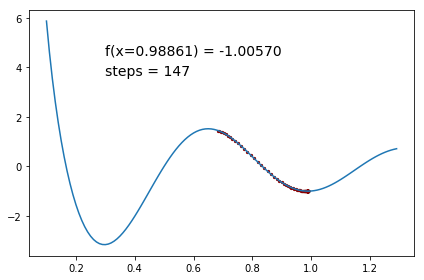

In [7]:
# every time you run this, it'll start at new initial location and find nearest minimum
import time
random.seed(int(round(time.time() * 1000))) # get new pseudo-random sequence each time
x0 = random.uniform(.1, 1.3)
viz_trace(x0, minimize_trace)

# Using symbolic derivatives

Instead of the finite difference solution, we can do a better job using the [symbolic derivative](https://m.wolframalpha.com/input/?i=derivative+cos%283*pi*x%29+%2F+x), which we can get for free for any function using Wolfram Alpha or [other tools](https://www.derivative-calculator.net/#expr=cos%283%2Api%2Ax%29%20%2F%20x&showsteps=1).  Finite difference is fine in theory but they don't work as well with finite precision floating point numbers (i.e., on a computer). Subtraction destroys precision, particularly when the operands are very similar.

\\[
\frac{d}{dx} \frac{cos(3\pi x)}{x} = - \frac{3 \pi x sin(3 \pi x) + cos(3 \pi x)}{x^2}
\\]

In [8]:
def minimize_dx(f, x0, eta, h, precision):
    tracex = [x0]
    x = x0
    while True:
        prev = x
        dx = - (3 * np.pi * x * np.sin(3*np.pi*x) + np.cos(3 * np.pi * x)) / x**2
        x = x - eta * dx 		# decelerates x step as it flattens out
#        print(f"x={x:.3f}, dx={dx:.3f}")
        tracex.append(x)
        if abs(x - prev) < precision:
            return tracex

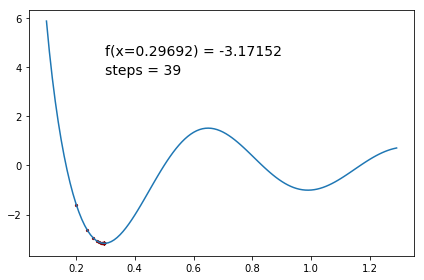

In [9]:
ETA = .001
random.seed(int(round(time.time() * 1000))) # get new pseudo-random sequence each time
x0 = random.uniform(.1, 1.3)
viz_trace(x0, minimize_dx)

## Summary

Lots of mathematical computing problems require an iterative solution. One of the most important is minimizing error functions to train machine learning models. The good news is that the gradient descent method described here follows the simple iterative method outline we saw when approximating square root. The next step is to extend gradient descent to two variables, which you will do as a project to solve a regression (line fitting) problem.